In [1]:
import numpy as np 
import pandas as pd
import pandas_profiling

import os 
import sys

import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from pyspark.sql.functions import col, avg
import seaborn as sns
from pyspark.sql.types import *


In [2]:
for dirname, _, filenames in os.walk('/Users/ashiranka/Desktop/USC/Course/FoundationsOfDataManagement/Project/AB_NYC_2019.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
spark = SparkSession.builder.appName("DSCI551").master("local[*]").getOrCreate()

In [4]:
#path to dataset and get the dataset 
filePath = "/Users/ashiranka/Desktop/USC/Course/FoundationsOfDataManagement/Project/AB_NYC_2019.csv"
nyAirbnbSchema = spark.read.csv(filePath, header=True, multiLine=True, inferSchema=True, quote='"', escape='"')

In [5]:
#Print the schema of the dataset to analyze the schema of the dataset available 
nyAirbnbSchema.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)



In [6]:
#Print count of rows
print("Number of rows/records : ", nyAirbnbSchema.count())

Number of rows/records :  48895


In [7]:
#Print the records on the dataset 
nyAirbnbSchema.show()

+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|       host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|            John|           Brooklyn|        Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|
|2595|Skylit Midtown Ca.

In [8]:
#While analysing the top 20 rows we can see that many attributes have lot of null values
#We can count number of null values for each attribute in the dataset 

# Count of number of null values for each attribute
print("Number of null values for each attribute :")
for col in nyAirbnbSchema.columns:
  print(col, ": ", nyAirbnbSchema.where(nyAirbnbSchema[col].isNull()).count())

Number of null values for each attribute :
id :  0
name :  16
host_id :  0
host_name :  21
neighbourhood_group :  0
neighbourhood :  0
latitude :  0
longitude :  0
room_type :  0
price :  0
minimum_nights :  0
number_of_reviews :  0
last_review :  10052
reviews_per_month :  10052
calculated_host_listings_count :  0
availability_365 :  0


In [9]:
#Clean the dataset : 
#1. Drop unecessary attributes which is not relevant to book a room: id and host_name
nyAirbnbSchema = nyAirbnbSchema.drop("id", "host_name","last_review")

In [10]:
#Replace all null values in reviews_per_month to 0 (0 reviews)
nyAirbnbSchema = nyAirbnbSchema.na.fill(0, ["reviews_per_month"])

In [11]:
# Count of number of null values for each attribute again 
print("Number of null values for each attribute after cleaning :")
for col in nyAirbnbSchema.columns:
  print(col, ": ", nyAirbnbSchema.where(nyAirbnbSchema[col].isNull()).count())

Number of null values for each attribute after cleaning :
name :  16
host_id :  0
neighbourhood_group :  0
neighbourhood :  0
latitude :  0
longitude :  0
room_type :  0
price :  0
minimum_nights :  0
number_of_reviews :  0
reviews_per_month :  0
calculated_host_listings_count :  0
availability_365 :  0


In [12]:
#Print the schema again to check if drop was sucessful
nyAirbnbSchema.printSchema()

root
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- reviews_per_month: double (nullable = false)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)



In [13]:
#Number of unique AirBnb's
nyAirbnbSchema.select("name").distinct().count()

47906

In [14]:
#Number of different neighbourhood_group
nyAirbnbSchema.select("neighbourhood_group").distinct().count()

5

In [15]:
#Number of AirBnb in different neighbourhood_group
neighbourhood_group_count = nyAirbnbSchema.groupby("neighbourhood_group").count().toPandas().head()
neighbourhood_group_count

,neighbourhood_group,count
0,Queens,5666
1,Brooklyn,20104
2,Staten Island,373
3,Manhattan,21661
4,Bronx,1091


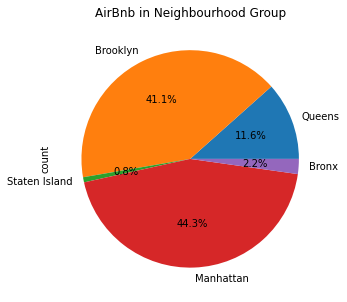

In [16]:
#Pie chart of different neighbourhood_group by count
neighbourhood_group_count.index = neighbourhood_group_count['neighbourhood_group']
plotPie = neighbourhood_group_count.plot.pie(y='count', autopct='%1.1f%%', legend = False, title='AirBnb in Neighbourhood Group', figsize=(10,5))




<AxesSubplot:xlabel='neighbourhood_group', ylabel='count'>

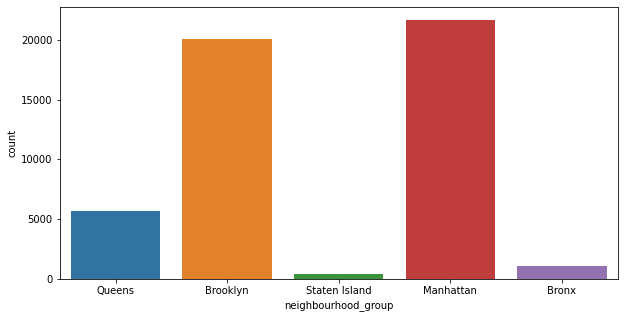

In [17]:
import matplotlib.pyplot as plotHist
%matplotlib inline

#Histogram of different neighbourhood_group by count
plotHist.figure(figsize=(10, 5))
sns.barplot(x="neighbourhood_group", y="count", data=neighbourhood_group_count)

In [18]:
#Average price of AirBnb in different neighbourhood_group 
neighbourhood_group_avgPrice = nyAirbnbSchema.groupBy("neighbourhood_group").agg(func.mean("price").alias("avg_price")).toPandas().head()
neighbourhood_group_avgPrice

,neighbourhood_group,avg_price
0,Queens,99.517649
1,Brooklyn,124.383207
2,Staten Island,114.812332
3,Manhattan,196.875814
4,Bronx,87.496792


<AxesSubplot:xlabel='neighbourhood_group', ylabel='avg_price'>

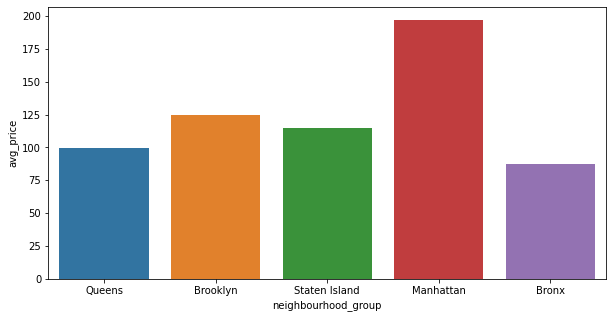

In [19]:
import matplotlib.pyplot as plotHist
%matplotlib inline

#Histogram of different neighbourhood_group by average price
plotHist.figure(figsize=(10, 5))
sns.barplot(x="neighbourhood_group", y="avg_price", data=neighbourhood_group_avgPrice)


In [20]:
#Number of different neighbourhood
nyAirbnbSchema.select("neighbourhood").distinct().count()

221

In [21]:
#Number of AirBnb in different neighbourhood
neighbourhood_count = nyAirbnbSchema.groupby("neighbourhood").count().orderBy('count', ascending=False).toPandas().head(15)
neighbourhood_count

,neighbourhood,count
0,Williamsburg,3920
1,Bedford-Stuyvesant,3714
2,Harlem,2658
3,Bushwick,2465
4,Upper West Side,1971
5,Hell's Kitchen,1958
6,East Village,1853
7,Upper East Side,1798
8,Crown Heights,1564
9,Midtown,1545


<AxesSubplot:xlabel='neighbourhood', ylabel='count'>

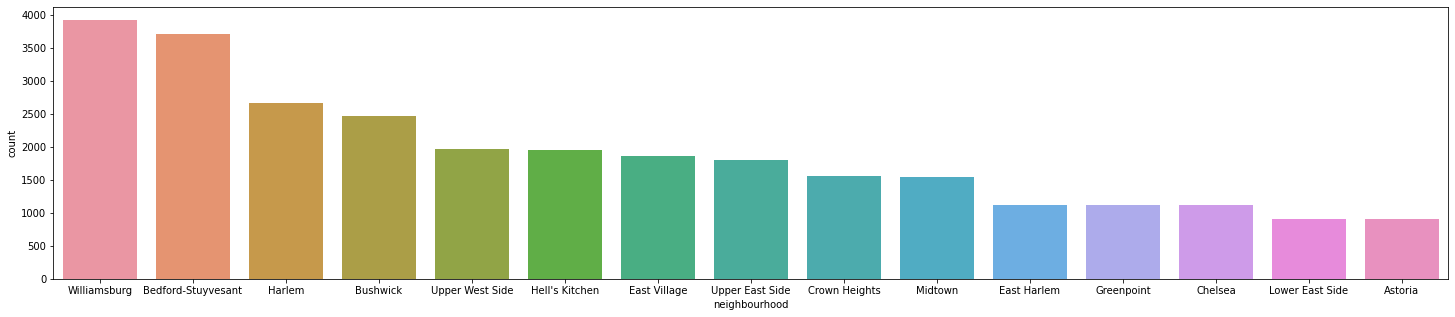

In [22]:
import matplotlib.pyplot as plotHist
%matplotlib inline

#Histogram of different neighbourhood by count
plotHist.figure(figsize=(25, 5))
sns.barplot(x="neighbourhood", y="count", data=neighbourhood_count)


In [23]:
#Average price of AirBnb in different neighbourhood 
neighbourhood_avgPrice = nyAirbnbSchema.groupBy("neighbourhood").agg(func.mean("price").alias("avg_price")).toPandas().head(15)
neighbourhood_avgPrice

,neighbourhood,avg_price
0,Corona,59.171875
1,Richmondtown,78.000000
2,Prince's Bay,409.500000
3,Westerleigh,71.500000
4,Mill Basin,179.750000
5,Civic Center,191.942308
6,Douglaston,82.750000
7,Mount Hope,77.500000
8,Marble Hill,89.166667
9,Rego Park,83.877358


<AxesSubplot:xlabel='neighbourhood', ylabel='avg_price'>

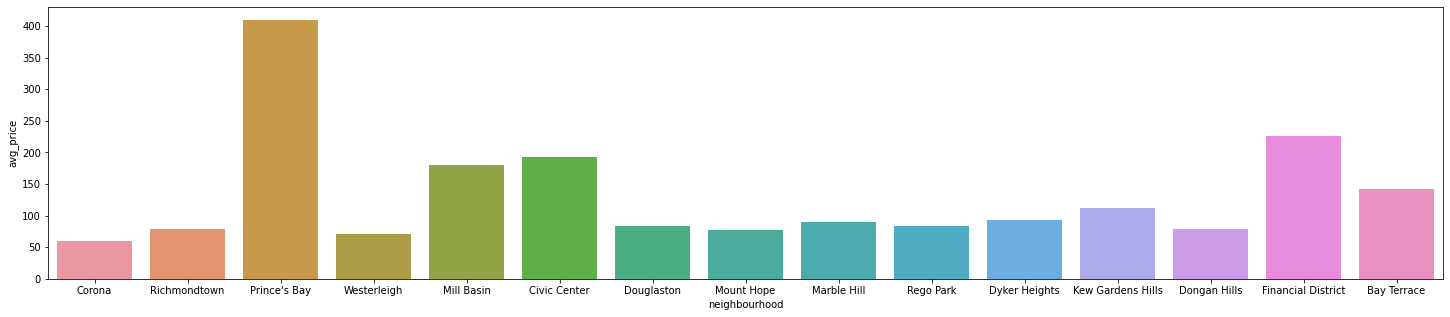

In [24]:
import matplotlib.pyplot as plotHist
%matplotlib inline

#Histogram of different neighbourhood by avg price
plotHist.figure(figsize=(25, 5))
sns.barplot(x="neighbourhood", y="avg_price", data=neighbourhood_avgPrice)

In [25]:
#Combining neighbourhood and neighbourhood_group
neigh_neighGroup = nyAirbnbSchema.select(nyAirbnbSchema["neighbourhood_group"], nyAirbnbSchema["neighbourhood"]).orderBy('neighbourhood_group',ascending=True).toPandas().head(20)
neigh_neighGroup


,neighbourhood_group,neighbourhood
0,Bronx,Highbridge
1,Bronx,Highbridge
2,Bronx,Clason Point
3,Bronx,Eastchester
4,Bronx,Kingsbridge
5,Bronx,Woodlawn
6,Bronx,University Heights
7,Bronx,Allerton
8,Bronx,Concourse Village
9,Bronx,Concourse


In [26]:
#Find different host_id 
nyAirbnbSchema.select("host_id").distinct().count()

37457

In [27]:
#Analyze AirBnb by different host_id and find top 15 host in New York 
host_id_count = nyAirbnbSchema.groupby("host_id").count().orderBy('count', ascending=False).toPandas().head(15)
host_id_count


,host_id,count
0,219517861,327
1,107434423,232
2,30283594,121
3,137358866,103
4,16098958,96
5,12243051,96
6,61391963,91
7,22541573,87
8,200380610,65
9,1475015,52


<AxesSubplot:xlabel='host_id', ylabel='count'>

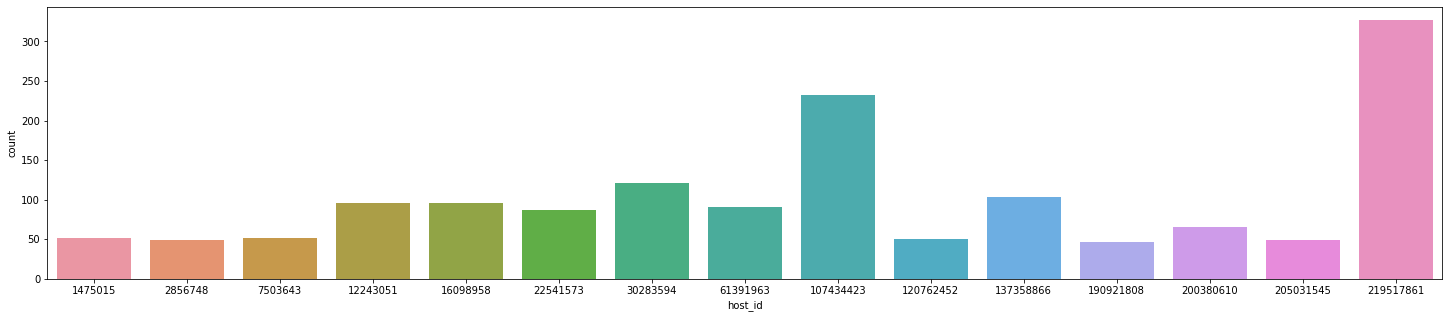

In [28]:
import matplotlib.pyplot as plotHist
%matplotlib inline

#Histogram of different host 
plotHist.figure(figsize=(25, 5))
sns.barplot(x="host_id", y="count", data=host_id_count)

In [29]:
# Count of different room_type
room_type_count = nyAirbnbSchema.where(nyAirbnbSchema.room_type.isin("Entire home/apt","Private room","Shared room")).groupBy(nyAirbnbSchema["room_type"]).count().orderBy('count', ascending=False).toPandas()
room_type_count


,room_type,count
0,Entire home/apt,25409
1,Private room,22326
2,Shared room,1160


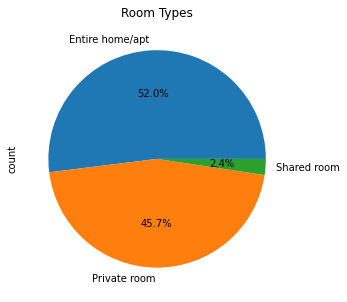

In [30]:
#Pie chart of different room_type
room_type_count.index = room_type_count['room_type']
plotPie = room_type_count.plot.pie(y='count', autopct='%1.1f%%', legend = False, title='Room Types', figsize=(10,5))



<AxesSubplot:xlabel='room_type', ylabel='count'>

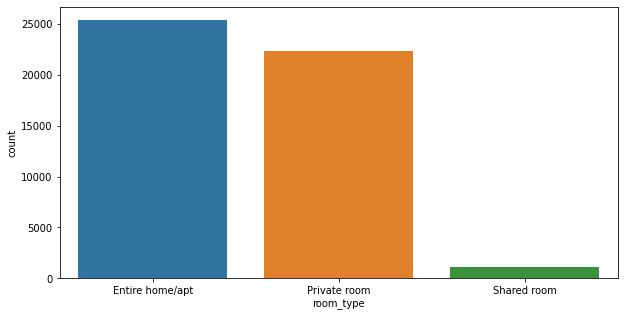

In [31]:
import matplotlib.pyplot as plotHist
%matplotlib inline

#Histogram of different host 
plotHist.figure(figsize=(10, 5))
sns.barplot(x="room_type", y="count", data=room_type_count)

In [32]:
#Average price of rooms
room_avgPrice = nyAirbnbSchema.agg(func.mean("price").alias("avg_price")).toPandas()
room_avgPrice

,avg_price
0,152.720687


In [33]:
#Average price of AirBnb based on room_type 
room_type_avgPrice = nyAirbnbSchema.groupBy("room_type").agg(func.mean("price").alias("avg_price")).toPandas()
room_type_avgPrice


,room_type,avg_price
0,Shared room,70.127586
1,Entire home/apt,211.794246
2,Private room,89.780973


<AxesSubplot:xlabel='room_type', ylabel='avg_price'>

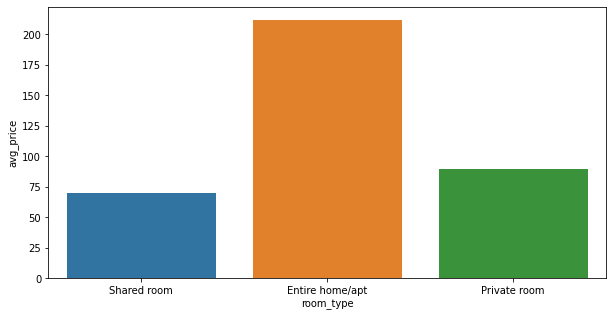

In [34]:
import matplotlib.pyplot as plotHist
%matplotlib inline

#Histogram of room_type : avg_price 
plotHist.figure(figsize=(10, 5))
sns.barplot(x="room_type", y="avg_price", data=room_type_avgPrice)

In [35]:
# Combining neighbourhood group with room_type
neighGrp_roomtype = nyAirbnbSchema.select(nyAirbnbSchema["neighbourhood_group"], nyAirbnbSchema["room_type"]).groupBy("neighbourhood_group", "room_type").count().orderBy('neighbourhood_group', ascending=True).toPandas()
neighGrp_roomtype



,neighbourhood_group,room_type,count
0,Bronx,Entire home/apt,379
1,Bronx,Shared room,60
2,Bronx,Private room,652
3,Brooklyn,Private room,10132
4,Brooklyn,Entire home/apt,9559
5,Brooklyn,Shared room,413
6,Manhattan,Entire home/apt,13199
7,Manhattan,Private room,7982
8,Manhattan,Shared room,480
9,Queens,Shared room,198


<AxesSubplot:xlabel='neighbourhood_group'>

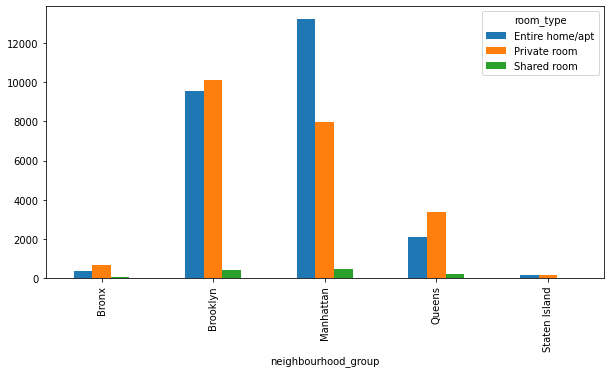

In [36]:
#Different Room type in different neighbourhood_group

pd.pivot_table(neighGrp_roomtype, index='neighbourhood_group', columns='room_type', values='count').plot.bar(figsize=(10,5))


In [37]:
# Combining neighbourhood group with room_type with avg_price
neighGrp_roomtype_avgprice = nyAirbnbSchema.select(nyAirbnbSchema["neighbourhood_group"], nyAirbnbSchema["room_type"],nyAirbnbSchema["price"]).groupBy("neighbourhood_group", "room_type").agg(func.mean("price").alias("avg_price")).orderBy('neighbourhood_group', ascending=True).toPandas()
neighGrp_roomtype_avgprice



,neighbourhood_group,room_type,avg_price
0,Bronx,Entire home/apt,127.506596
1,Bronx,Shared room,59.800000
2,Bronx,Private room,66.788344
3,Brooklyn,Private room,76.500099
4,Brooklyn,Entire home/apt,178.327545
5,Brooklyn,Shared room,50.527845
6,Manhattan,Entire home/apt,249.239109
7,Manhattan,Private room,116.776622
8,Manhattan,Shared room,88.977083
9,Queens,Shared room,69.020202


<AxesSubplot:xlabel='neighbourhood_group'>

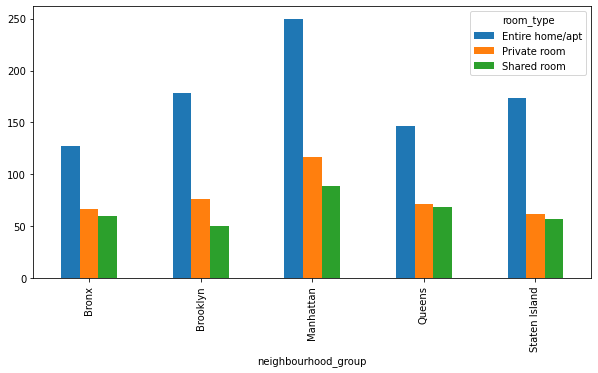

In [38]:
#Different Room type in different neighbourhood_group with avg_price

pd.pivot_table(neighGrp_roomtype_avgprice, index='neighbourhood_group', columns='room_type', values='avg_price').plot.bar(figsize=(10,5))


In [39]:
# Combining neighbourhood with room_type
neigh_roomtype = nyAirbnbSchema.select(nyAirbnbSchema["neighbourhood"], nyAirbnbSchema["room_type"]).groupBy("neighbourhood", "room_type").count().orderBy('neighbourhood', ascending=True).toPandas().head(15)
neigh_roomtype


,neighbourhood,room_type,count
0,Allerton,Private room,26
1,Allerton,Entire home/apt,16
2,Arden Heights,Entire home/apt,3
3,Arden Heights,Private room,1
4,Arrochar,Private room,11
5,Arrochar,Entire home/apt,10
6,Arverne,Private room,27
7,Arverne,Shared room,2
8,Arverne,Entire home/apt,48
9,Astoria,Shared room,25


<AxesSubplot:xlabel='neighbourhood'>

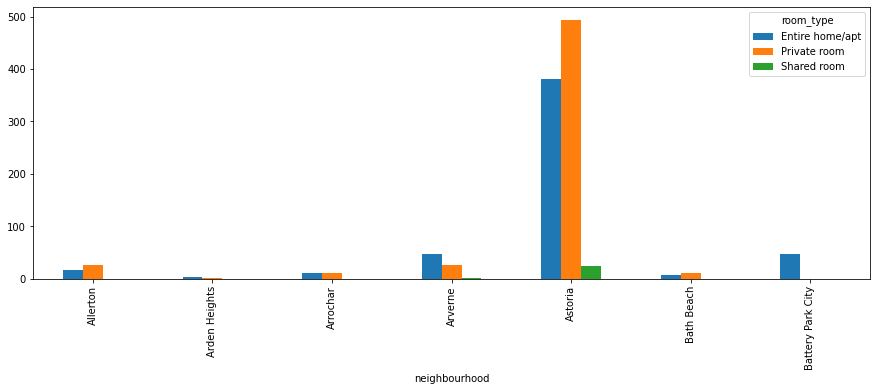

In [40]:
#Different Room type in different neighbourhood

pd.pivot_table(neigh_roomtype, index='neighbourhood', columns='room_type', values='count').plot.bar(figsize=(15,5))


In [41]:
# Combining neighbourhood with room_type with avg_price
neigh_roomtype_avgprice = nyAirbnbSchema.select(nyAirbnbSchema["neighbourhood"], nyAirbnbSchema["room_type"],nyAirbnbSchema["price"]).groupBy("neighbourhood", "room_type").agg(func.mean("price").alias("avg_price")).orderBy('neighbourhood', ascending=True).toPandas().head(15)
neigh_roomtype_avgprice


,neighbourhood,room_type,avg_price
0,Allerton,Private room,65.769231
1,Allerton,Entire home/apt,123.062500
2,Arden Heights,Entire home/apt,76.000000
3,Arden Heights,Private room,41.000000
4,Arrochar,Private room,47.090909
5,Arrochar,Entire home/apt,189.700000
6,Arverne,Private room,87.740741
7,Arverne,Shared room,38.000000
8,Arverne,Entire home/apt,224.625000
9,Astoria,Shared room,151.160000


<AxesSubplot:xlabel='neighbourhood'>

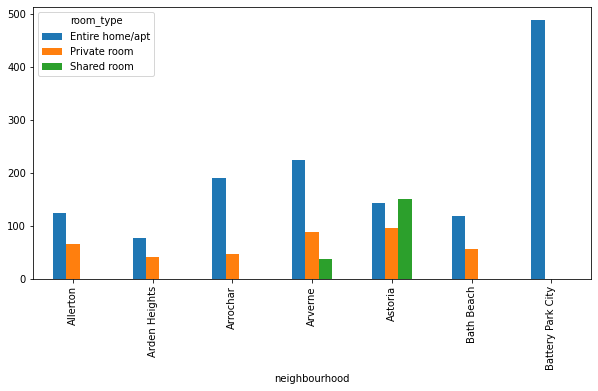

In [42]:
#Different Room type in different neighbourhood with avg_price

pd.pivot_table(neigh_roomtype_avgprice, index='neighbourhood', columns='room_type', values='avg_price').plot.bar(figsize=(10,5))


In [43]:
#Minimum nights guest stay at an AirBnb
min_night_count = nyAirbnbSchema.groupby("minimum_nights").count().orderBy('count', ascending=False).toPandas().head(15)
min_night_count


,minimum_nights,count
0,1,12720
1,2,11696
2,3,7999
3,30,3760
4,4,3303
5,5,3034
6,7,2058
7,6,752
8,14,562
9,10,483


<AxesSubplot:xlabel='minimum_nights', ylabel='count'>

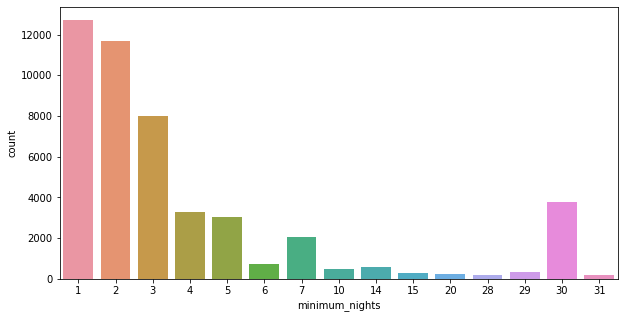

In [44]:
#Minimum nights count
plotHist.figure(figsize=(10, 5))
sns.barplot(x="minimum_nights", y="count", data=min_night_count)

In [45]:
#Average price of AirBnb based on number_of_reviews
num_reviews_avgPrice = nyAirbnbSchema.groupBy("number_of_reviews").agg(func.mean("price").alias("avg_price")).orderBy('number_of_reviews', ascending=False).toPandas().head(15)
num_reviews_avgPrice

,number_of_reviews,avg_price
0,629,47.0
1,607,49.0
2,597,49.0
3,594,49.0
4,576,47.0
5,543,46.0
6,540,99.0
7,510,48.0
8,488,160.0
9,480,60.0


<AxesSubplot:xlabel='number_of_reviews', ylabel='avg_price'>

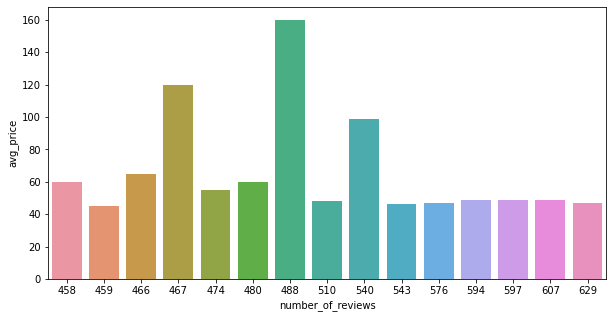

In [46]:
#Number of reviews vs avg price histogram
plotHist.figure(figsize=(10, 5))
sns.barplot(x="number_of_reviews", y="avg_price", data=num_reviews_avgPrice)

In [47]:
#Average reviews of AirBnb in different neighbourhood_group 
neighbourhoodGroup_numRev = nyAirbnbSchema.groupBy("neighbourhood_group").agg(func.mean("number_of_reviews").alias("num_of_reviews")).orderBy('num_of_reviews', ascending=False).toPandas().head(15)
neighbourhoodGroup_numRev


,neighbourhood_group,num_of_reviews
0,Staten Island,30.941019
1,Queens,27.700318
2,Bronx,26.004583
3,Brooklyn,24.202845
4,Manhattan,20.985596


<AxesSubplot:xlabel='neighbourhood_group', ylabel='num_of_reviews'>

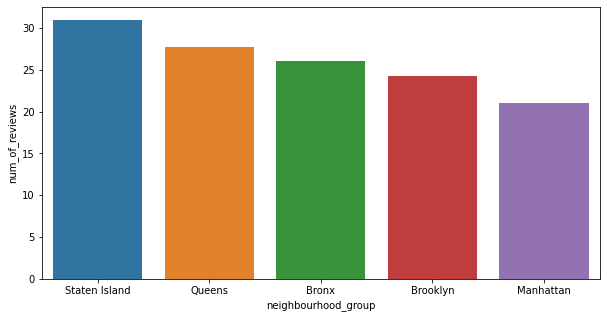

In [48]:
#histogram Average reviews of AirBnb in different neighbourhood_group
plotHist.figure(figsize=(10, 5))
sns.barplot(x="neighbourhood_group", y="num_of_reviews", data=neighbourhoodGroup_numRev)

In [49]:
#Average reviews of AirBnb in different neighbourhood 
neighbourhood_numRev = nyAirbnbSchema.groupBy("neighbourhood").agg(func.mean("number_of_reviews").alias("num_of_reviews")).orderBy('num_of_reviews', ascending=False).toPandas().head(15)
neighbourhood_numRev

,neighbourhood,num_of_reviews
0,Silver Lake,118.500000
1,East Elmhurst,81.659459
2,Richmondtown,79.000000
3,Eltingville,76.000000
4,Mount Eden,70.000000
5,Springfield Gardens,69.094118
6,Tompkinsville,57.142857
7,Huguenot,55.666667
8,Manhattan Beach,50.625000
9,Highbridge,48.814815


<AxesSubplot:xlabel='neighbourhood', ylabel='num_of_reviews'>

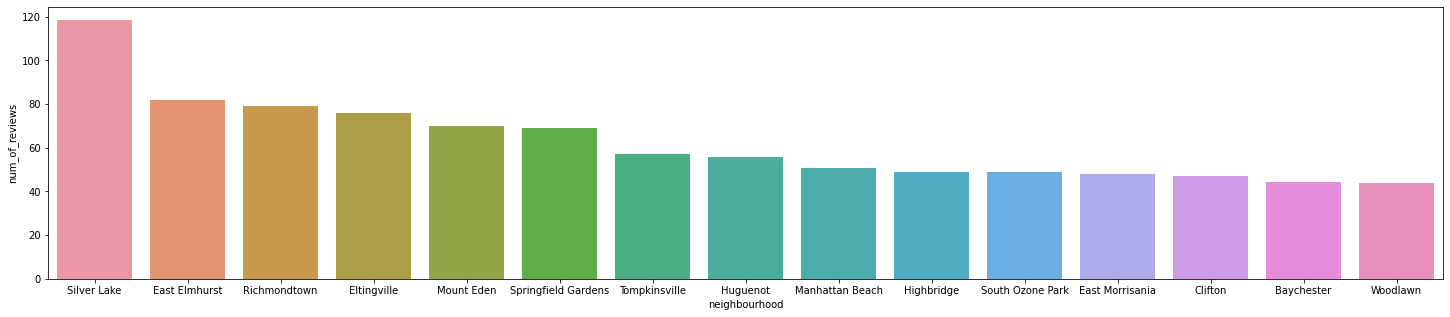

In [50]:
#histogram Average reviews of AirBnb in different neighbourhood
plotHist.figure(figsize=(25, 5))
sns.barplot(x="neighbourhood", y="num_of_reviews", data=neighbourhood_numRev)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

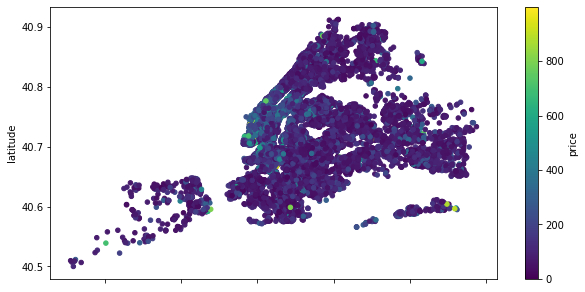

In [51]:
#Price in different latitude longitude
import matplotlib.pyplot as matp
nyAirbnbSchema_plot = nyAirbnbSchema.toPandas()
nyAirbnbSchema_plot_trim = nyAirbnbSchema_plot[nyAirbnbSchema_plot['price'] < 1000]
nyAirbnbSchema_plot_trim.plot.scatter(x='longitude', y='latitude', c='price', cmap=matp.get_cmap('viridis'), figsize=(10,5))



<AxesSubplot:xlabel='longitude', ylabel='latitude'>

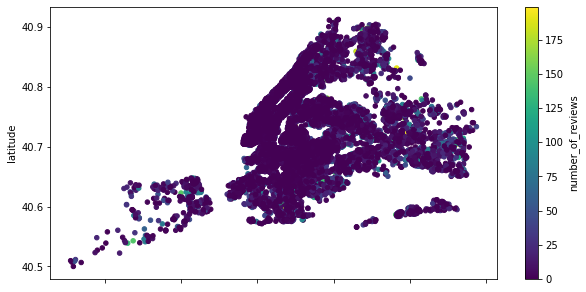

In [52]:
#Number of reviews in different latitude longitude
import matplotlib.pyplot as matp
nyAirbnbSchema_plot = nyAirbnbSchema.toPandas()
nyAirbnbSchema_plot_trim = nyAirbnbSchema_plot[nyAirbnbSchema_plot['number_of_reviews'] < 200]
nyAirbnbSchema_plot_trim.plot.scatter(x='longitude', y='latitude', c='number_of_reviews', cmap=matp.get_cmap('viridis'), figsize=(10,5))




<AxesSubplot:xlabel='longitude', ylabel='latitude'>

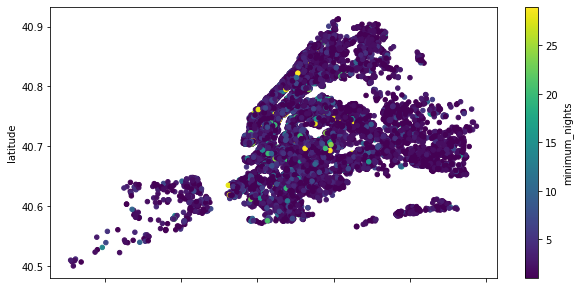

In [53]:
#Min nights in different latitude longitude
import matplotlib.pyplot as matp
nyAirbnbSchema_plot = nyAirbnbSchema.toPandas()
nyAirbnbSchema_plot_trim = nyAirbnbSchema_plot[nyAirbnbSchema_plot['minimum_nights'] < 30]
nyAirbnbSchema_plot_trim.plot.scatter(x='longitude', y='latitude', c='minimum_nights', cmap=matp.get_cmap('viridis'), figsize=(10,5))




In [54]:
#Save cleaned data to local file in csv format
nyAirbnbSchema.coalesce(1).write.csv('/Users/ashiranka/Desktop/USC/Course/FoundationsOfDataManagement/Project/airBnbNewYork.csv', mode='overwrite', sep='\t', header=True)


In [55]:
#Save cleaned data to local file in json format
nyAirbnbSchema.coalesce(1).write.json('/Users/ashiranka/Desktop/USC/Course/FoundationsOfDataManagement/Project/airBnbNewYork.json', mode='overwrite')
